Opened sites: 3 / P=3
Covered demand: 30.0  (15.4%)


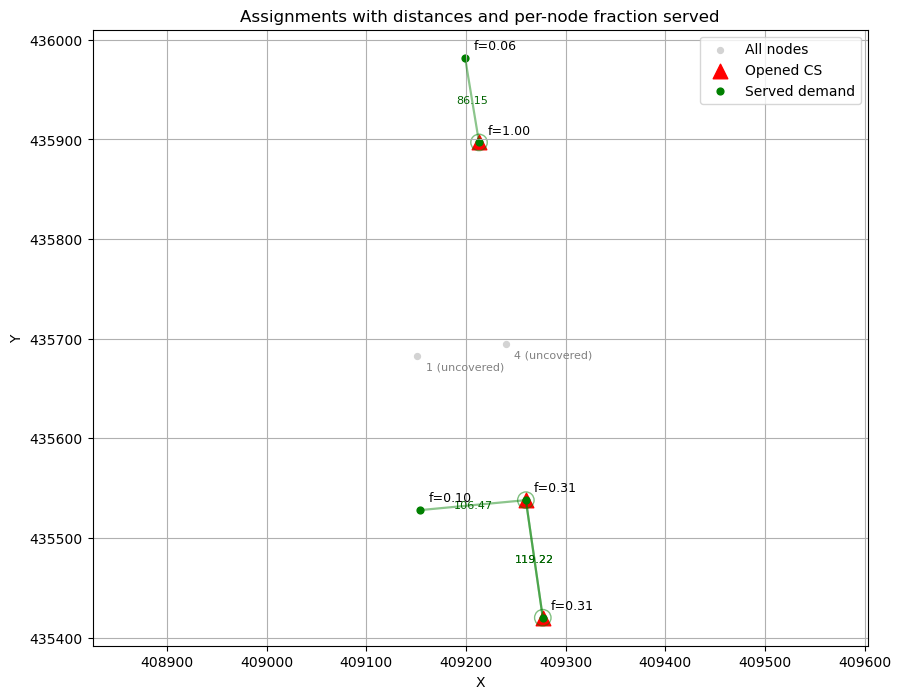

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt

#import from the installed package
from evcs import (
    load_instance, build_arcs, compute_farther,
    build_base_model, add_closest_only,
    solve_model, extract_solution,
)
from evcs.plot import plot_solution_pretty

def find_project_root(marker="data", max_up=5):
    """Walk up until a folder containing `marker` exists."""
    p = Path.cwd().resolve()
    for _ in range(max_up):
        if (p / marker).exists():
            return p
        p = p.parent
    raise FileNotFoundError(f"Could not find project root with '{marker}/' folder.")

if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = find_project_root("data")

#load data
DATA = ROOT / "data"
LOC_PATH = DATA / "location_data_NA7.txt"
DEM_PATH = DATA / "demand_data_NA7.txt"

D = 150.0      # max distance
Q = 10.0       # capacity per station
P = 3          # number of stations
FORBID_SELF = False  # allow i->i assignment

# quick sanity
assert LOC_PATH.exists(), f"Missing {LOC_PATH}"
assert DEM_PATH.exists(), f"Missing {DEM_PATH}"

#load coorninate of nodes
inst = load_instance(LOC_PATH, DEM_PATH)
distIJ, in_range, Ji, Ij = build_arcs(
    inst["coords_I"], inst["coords_J"], D,
    forbid_self=FORBID_SELF,
    I_idx=inst["I_idx"], J_idx=inst["J_idx"]
)
farther_of = compute_farther(distIJ, in_range, Ji)

#build the base model
m = build_base_model(
    M=len(inst["I_idx"]), N=len(inst["J_idx"]),
    in_range=in_range, Ji=Ji, Ij=Ij,
    demand_I=inst["demand_I"], Q=Q, P=P
)
from evcs import add_closest_priority
add_closest_priority(m, distIJ, in_range, Ji, Ij)


#solve
solve_model(m, verbose=False)

#extract & report
sol = extract_solution(m, in_range)
opened_rows = [inst["J_idx"][j] for j in sol["opened_J"]]
coverage_pct = 100.0 * sol["covered"] / float(inst["demand_I"].sum())
print(f"Opened sites: {len(opened_rows)} / P={P}")
print(f"Covered demand: {sol['covered']:.1f}  ({coverage_pct:.1f}%)")

#plot
plt.figure(figsize=(10, 8))
plot_solution_pretty(
    m,
    inst["location_df"],
    inst["coords"],
    inst["I_idx"],
    inst["J_idx"],
    in_range,
    show_self="ring"
)
plt.show()
